# Marketing Case Study

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler 
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings("ignore")

## Customer Segmentation

A key objective is to create a predictive model which allows the company to maximize the profits of the next marketing campaign.

In [3]:
# load data
with open("processed_data.csv", "r") as f:
    data = pd.read_csv(f)

data.head()

,Unnamed: 0,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,...,AcceptedCmp2,Response,Complain,Country,Age,Length_customer_yrs,Dependents,Total_Spent,total_purchases,Total_Accepted_Camp
0,0,Graduation,Divorced,84835.0,0,0,0,15.88,8.74,31.85,...,0,1,0,SP,52,8.03,0,1190,14,0
1,1,Graduation,Single,57091.0,0,0,0,80.42,0.87,11.09,...,1,1,0,CA,61,8.03,0,577,17,1
2,2,Graduation,Married,67267.0,0,1,0,53.39,4.38,23.51,...,0,0,0,US,64,8.12,1,251,10,0
3,3,Graduation,Together,32474.0,1,1,0,90.91,0.00,9.09,...,0,0,0,AUS,55,8.13,2,11,3,0
4,4,Graduation,Single,21474.0,1,0,0,6.59,17.58,26.37,...,0,1,0,SP,33,8.22,1,91,6,1


In [4]:
data.drop(columns=["Unnamed: 0", "Response"], inplace=True)

In [5]:
# data.columns.to_list()

In [6]:
# The KMeans algorithm does not perform well with binary data.

seg_cols = ['Education',
 'Marital_Status',
 'Income',
 'Recency',
 'MntWines',
 'MntFruits',
 'MntMeatProducts',
 'MntFishProducts',
 'MntSweetProducts',
 'MntGoldProds',
 'NumDealsPurchases',
 'NumWebVisitsMonth',
 'Complain',
 'Country',
 'Age',
 'Length_customer_yrs',
 'Dependents',
 'Total_Spent',
 'total_purchases',
 'Total_Accepted_Camp']

In [7]:
seg_df = pd.DataFrame(data[seg_cols])

In [8]:
seg_df.head()

,Education,Marital_Status,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebVisitsMonth,Complain,Country,Age,Length_customer_yrs,Dependents,Total_Spent,total_purchases,Total_Accepted_Camp
0,Graduation,Divorced,84835.0,0,15.88,8.74,31.85,9.33,15.88,18.32,1,1,0,SP,52,8.03,0,1190,14,0
1,Graduation,Single,57091.0,0,80.42,0.87,11.09,1.21,0.00,6.41,1,5,0,CA,61,8.03,0,577,17,1
2,Graduation,Married,67267.0,0,53.39,4.38,23.51,5.98,0.80,11.95,1,2,0,US,64,8.12,1,251,10,0
3,Graduation,Together,32474.0,0,90.91,0.00,9.09,0.00,0.00,0.00,1,7,0,AUS,55,8.13,2,11,3,0
4,Graduation,Single,21474.0,0,6.59,17.58,26.37,12.09,0.00,37.36,2,7,0,SP,33,8.22,1,91,6,1


In [9]:
seg_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2190 entries, 0 to 2189
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Education            2190 non-null   object 
 1   Marital_Status       2190 non-null   object 
 2   Income               2190 non-null   float64
 3   Recency              2190 non-null   int64  
 4   MntWines             2190 non-null   float64
 5   MntFruits            2190 non-null   float64
 6   MntMeatProducts      2190 non-null   float64
 7   MntFishProducts      2190 non-null   float64
 8   MntSweetProducts     2190 non-null   float64
 9   MntGoldProds         2190 non-null   float64
 10  NumDealsPurchases    2190 non-null   int64  
 11  NumWebVisitsMonth    2190 non-null   int64  
 12  Complain             2190 non-null   int64  
 13  Country              2190 non-null   object 
 14  Age                  2190 non-null   int64  
 15  Length_customer_yrs  2190 non-null   f

In [10]:
del data

## Pre-Processing Data

Performing customer segmentation using machine learning requires some preprocessing of the data.
- First, if the data are skewed, then the data needs to be transformed
- Next, there are a few categorical features that need to be encoded
- Finally, the data are centered and scaled using StandardScaler() method.

Use sklearn pipeline to streamline the pre-processing of data needed before modeling.

https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html#sphx-glr-auto-examples-compose-plot-column-transformer-mixed-types-py

In [11]:
# scale numerical features
num_features = seg_df.select_dtypes(exclude="object").columns
num_scaler = Pipeline(
    steps=[('scaler', StandardScaler())]
)

# nominal categorical data
nom_cat = ['Marital_Status', 'Country']
one_hot_encoder = OneHotEncoder(handle_unknown="ignore")

# ordered categorical data
ord_cat = ['Education']
ord_encoder = OrdinalEncoder()

preprocessor = ColumnTransformer(
    transformers= [
        ("scaler", num_scaler, num_features),
        ("nom", one_hot_encoder, nom_cat),
        ("ord", ord_encoder, ord_cat)
    ]
)

In [12]:
# preprocessor

In [13]:
prep_data = preprocessor.fit_transform(seg_df)

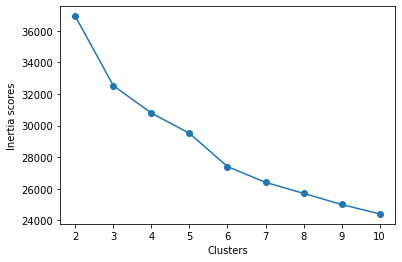

In [14]:
inertia_scores = []
silhouette_scores = []

for n in range(2, 11):
    kmeans = KMeans(n_clusters = n, init="k-means++", random_state =43)
    kmeans.fit(prep_data)
    inertia_scores.append(kmeans.inertia_)
    sscore = silhouette_score(prep_data, kmeans.labels_)
    silhouette_scores.append(sscore)

plt.plot(range(2, 11), inertia_scores, marker = "o")
plt.xlabel("Clusters")
plt.ylabel("Inertia scores")
plt.show()

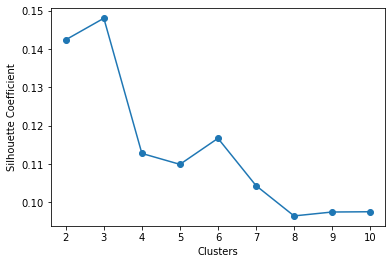

In [15]:
plt.plot(range(2, 11), silhouette_scores, marker = "o")
plt.xticks(range(2,11))
plt.xlabel("Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

Another method to used evaluate what value of k to use is with the kneed module.

In [16]:
from kneed import KneeLocator

kl = KneeLocator(
    range(2, 11), inertia_scores, curve="convex", direction="decreasing"
)

In [17]:
kl.elbow

6

## Create Model with 3 Clusters

Add KMeans model to pipeline with 3 clusters.

We will also use PCA to reduce the number of dimensions from 20 to 2

In [18]:
from sklearn.decomposition import PCA

reduce_dim = Pipeline(
    [('reduce_dim', 
        PCA(n_components=2, random_state=42)
        )])

In [19]:
n_clusters = 3

segmenter = Pipeline(
    [("kmeans",
        KMeans(
            n_clusters=n_clusters,
            init="k-means++",
            n_init=10,
            max_iter=300,
            random_state=3
        ))])

In [20]:
clf_pipe = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("reduce_dim", reduce_dim),
        ("segmenter", segmenter)
        ])

In [21]:
kmeans = clf_pipe.fit(seg_df)
preds = kmeans.predict(seg_df)
seg_df['Cluster'] = preds + 1

In [22]:
# counts of clusters with PCA
seg_df['Cluster'].value_counts()

1    910
2    670
3    610
Name: Cluster, dtype: int64

In [23]:
# count of clusters before PCA
# seg_df['Cluster'].value_counts()

In [24]:
pcadf = pd.DataFrame(
    clf_pipe[:-1].transform(seg_df),
    columns=["component_1", "component_2"])

pcadf["predicted_cluster"] = clf_pipe["segmenter"]["kmeans"].labels_

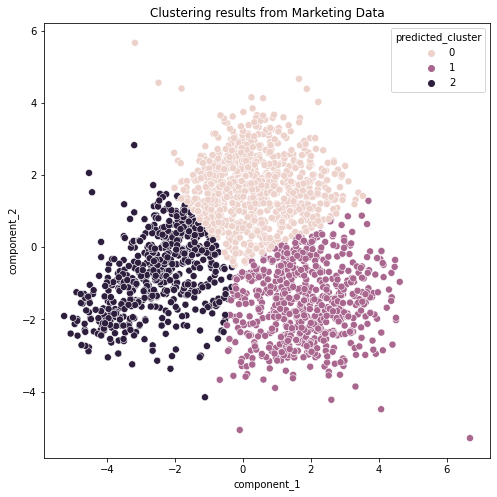

In [25]:
plt.figure(figsize=(8,8))
g = sns.scatterplot(
    "component_1", "component_2",
    data=pcadf,
    hue="predicted_cluster",
    s=50
)
g.set_title("Clustering results from Marketing Data")
plt.show()

In [26]:
pcadf.head()

,component_1,component_2,predicted_cluster
0,0.281521,-3.257618,1
1,1.828689,0.534799,0
2,0.437444,-0.023757,0
3,-0.278708,2.971412,0
4,-3.235258,-1.127971,2


In [27]:
seg_df.head()

,Education,Marital_Status,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,...,NumWebVisitsMonth,Complain,Country,Age,Length_customer_yrs,Dependents,Total_Spent,total_purchases,Total_Accepted_Camp,Cluster
0,Graduation,Divorced,84835.0,0,15.88,8.74,31.85,9.33,15.88,18.32,...,1,0,SP,52,8.03,0,1190,14,0,2
1,Graduation,Single,57091.0,0,80.42,0.87,11.09,1.21,0.00,6.41,...,5,0,CA,61,8.03,0,577,17,1,1
2,Graduation,Married,67267.0,0,53.39,4.38,23.51,5.98,0.80,11.95,...,2,0,US,64,8.12,1,251,10,0,1
3,Graduation,Together,32474.0,0,90.91,0.00,9.09,0.00,0.00,0.00,...,7,0,AUS,55,8.13,2,11,3,0,1
4,Graduation,Single,21474.0,0,6.59,17.58,26.37,12.09,0.00,37.36,...,7,0,SP,33,8.22,1,91,6,1,3


In [28]:
final_df = pd.merge(seg_df, pcadf, left_index=True, right_index=True)
final_df.drop(columns=["predicted_cluster"], inplace=True)
final_df.head()

,Education,Marital_Status,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,...,Country,Age,Length_customer_yrs,Dependents,Total_Spent,total_purchases,Total_Accepted_Camp,Cluster,component_1,component_2
0,Graduation,Divorced,84835.0,0,15.88,8.74,31.85,9.33,15.88,18.32,...,SP,52,8.03,0,1190,14,0,2,0.281521,-3.257618
1,Graduation,Single,57091.0,0,80.42,0.87,11.09,1.21,0.00,6.41,...,CA,61,8.03,0,577,17,1,1,1.828689,0.534799
2,Graduation,Married,67267.0,0,53.39,4.38,23.51,5.98,0.80,11.95,...,US,64,8.12,1,251,10,0,1,0.437444,-0.023757
3,Graduation,Together,32474.0,0,90.91,0.00,9.09,0.00,0.00,0.00,...,AUS,55,8.13,2,11,3,0,1,-0.278708,2.971412
4,Graduation,Single,21474.0,0,6.59,17.58,26.37,12.09,0.00,37.36,...,SP,33,8.22,1,91,6,1,3,-3.235258,-1.127971


In [29]:
# for each column in seg_df, get some kind of aggregate statistic to compare each cluster
for col in seg_df.columns:
    
    seg_df.groupby("Cluster")[col].sum()

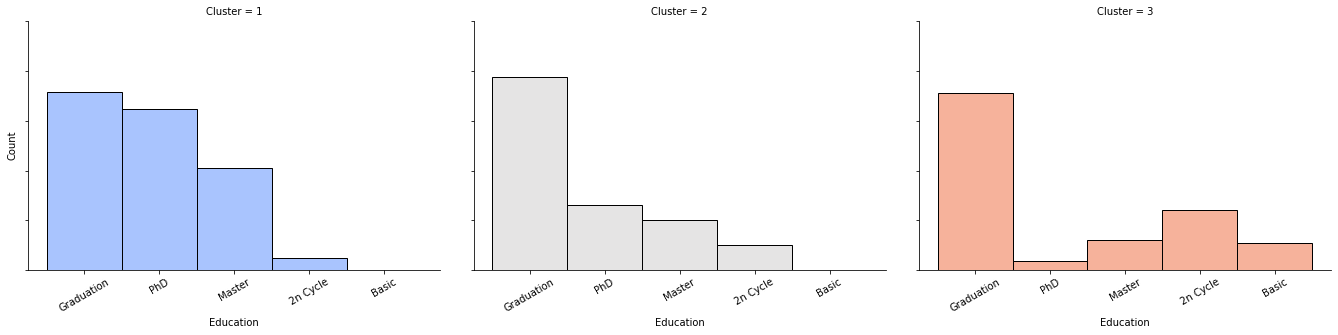

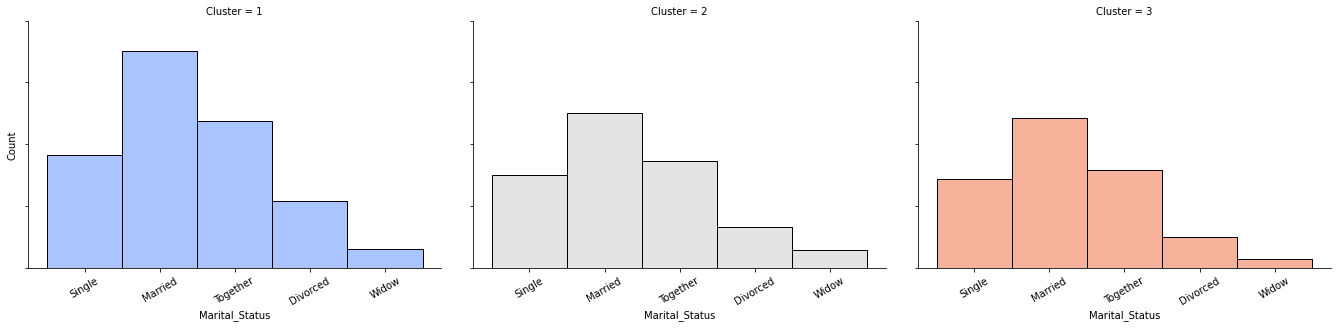

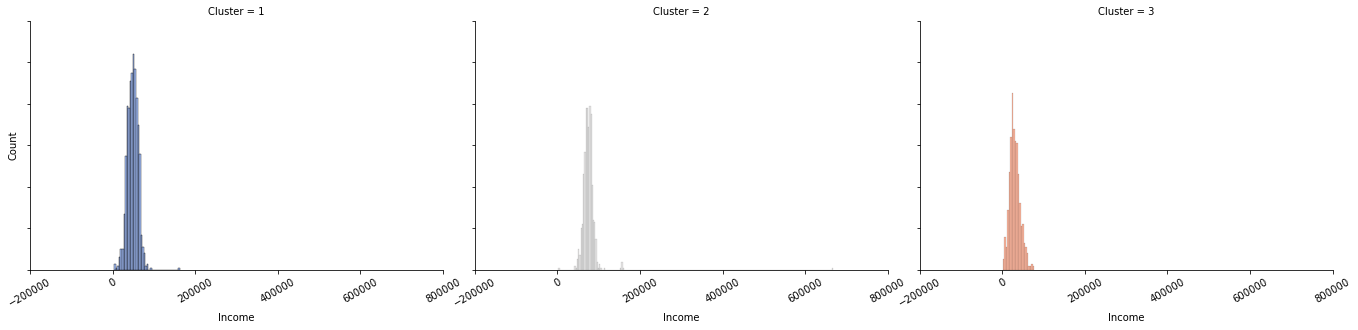

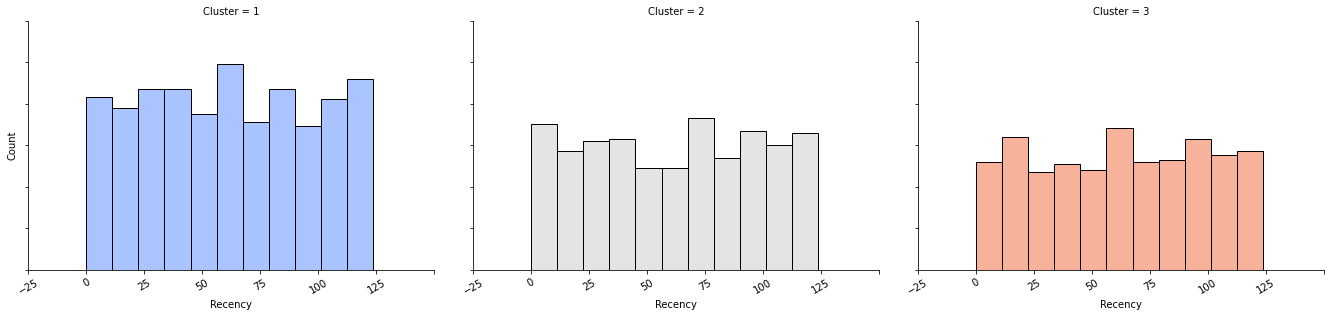

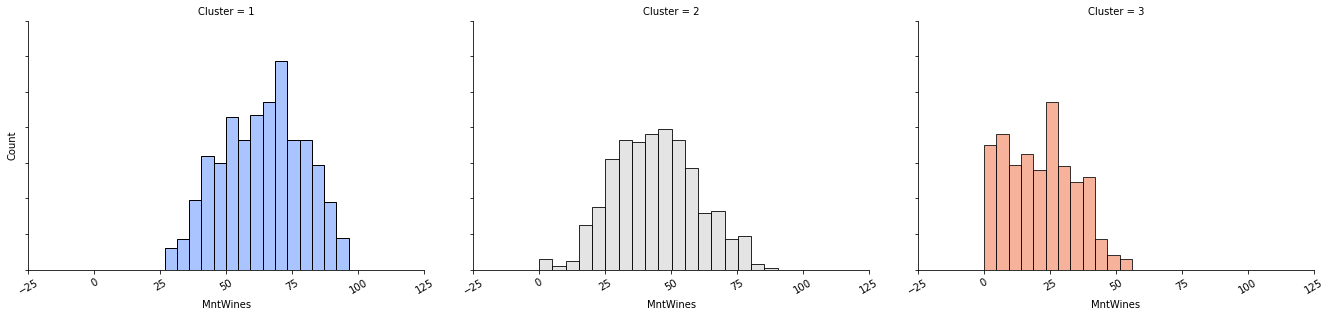

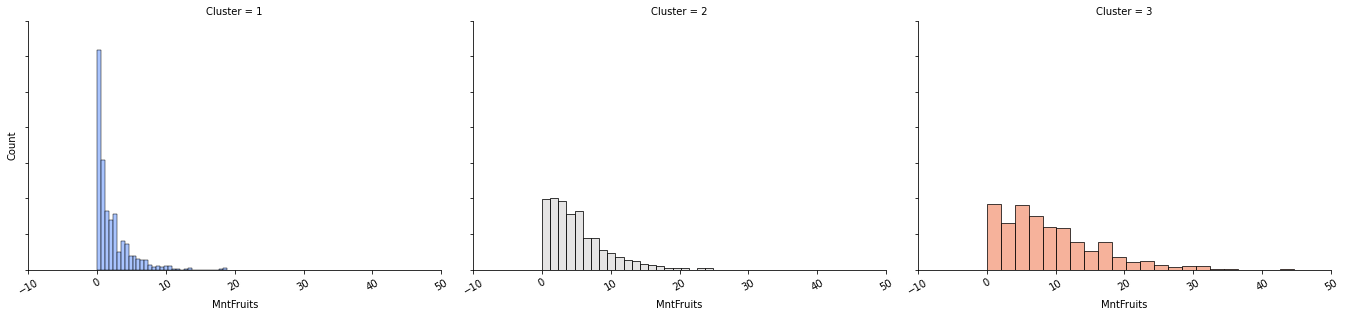

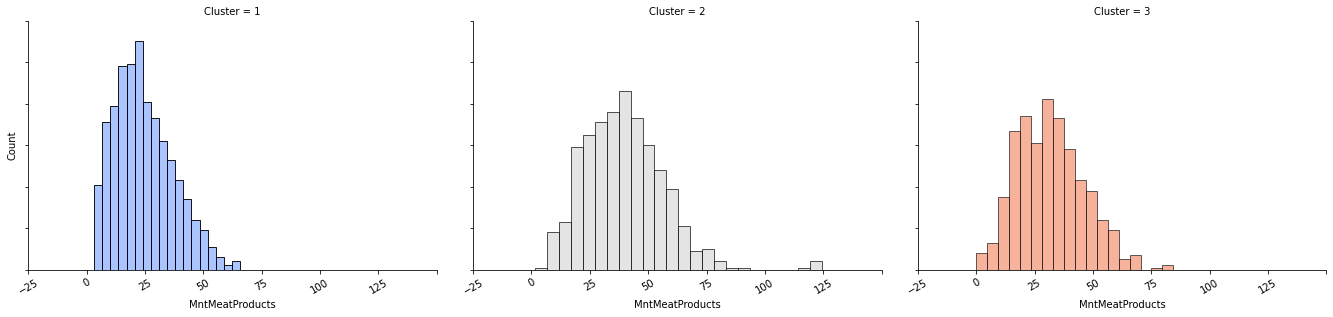

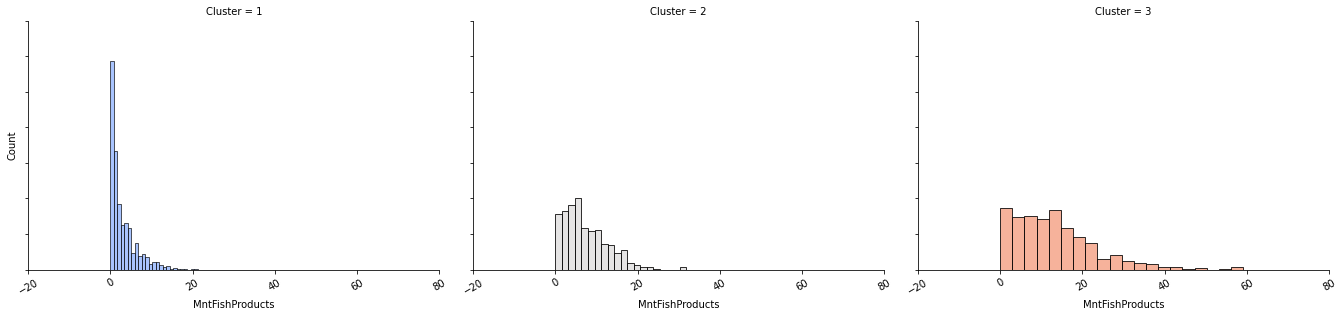

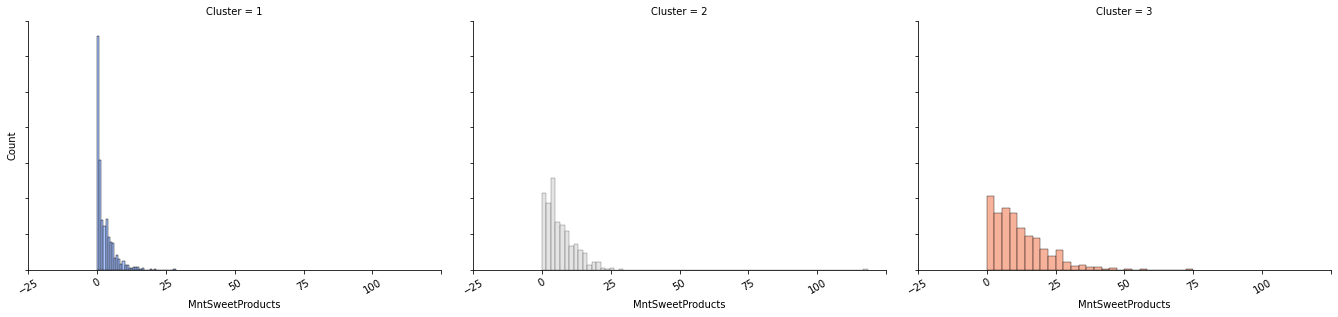

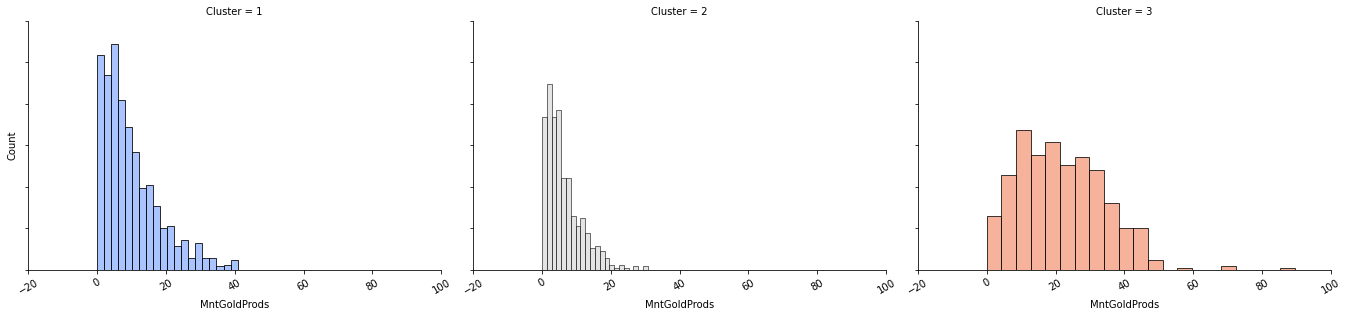

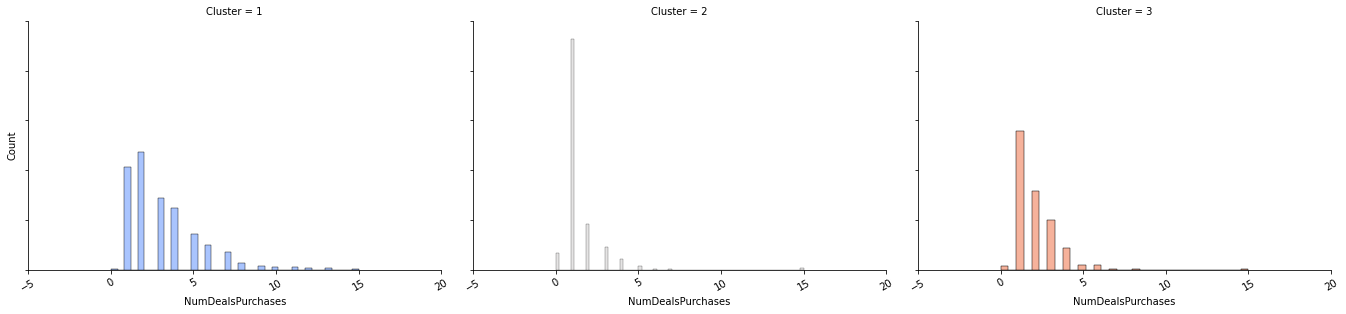

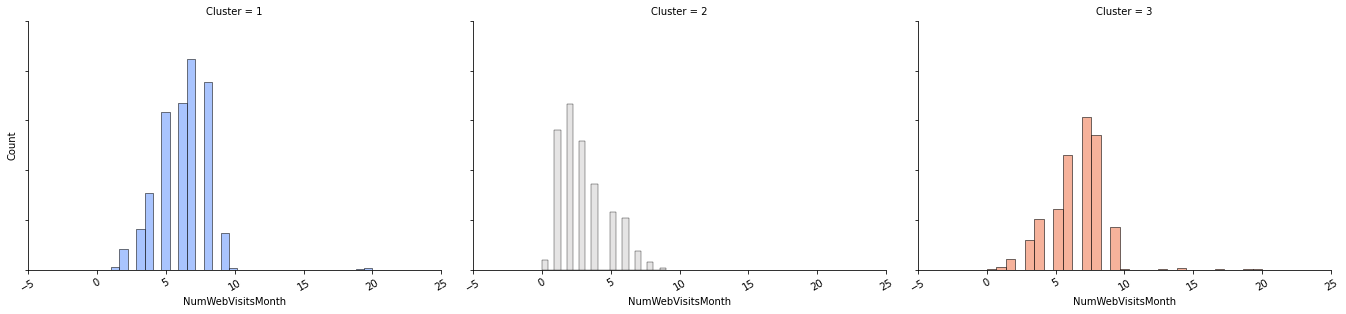

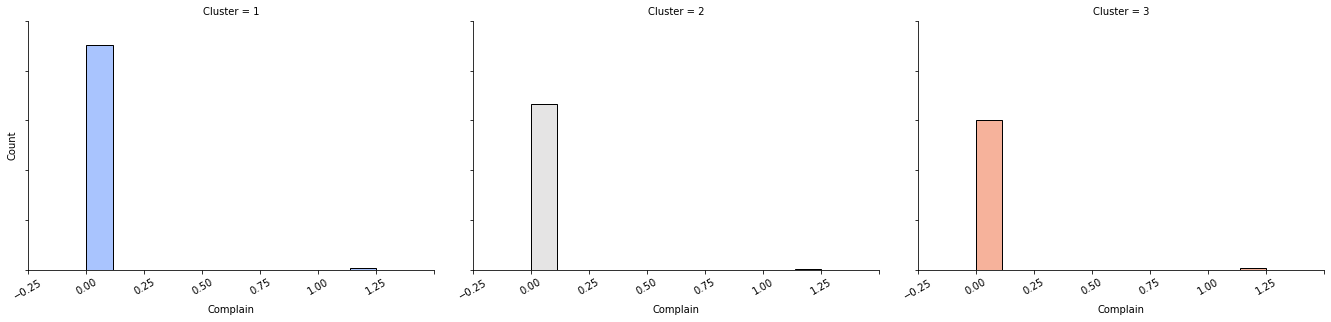

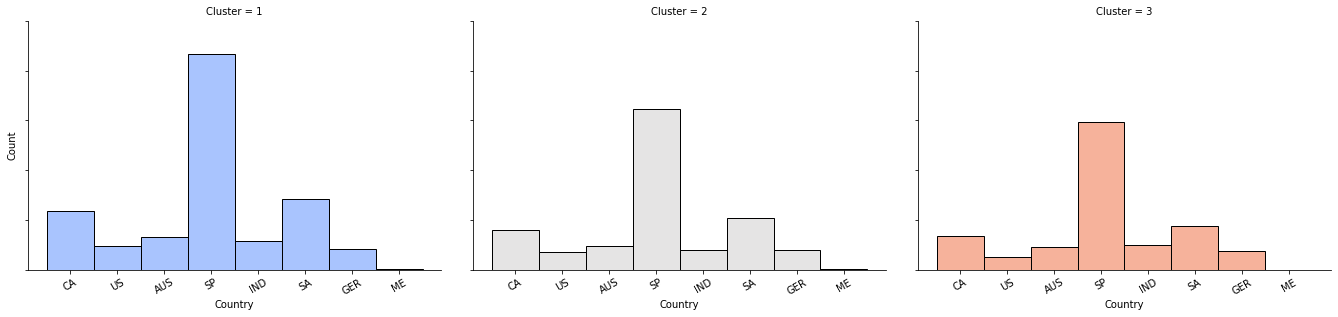

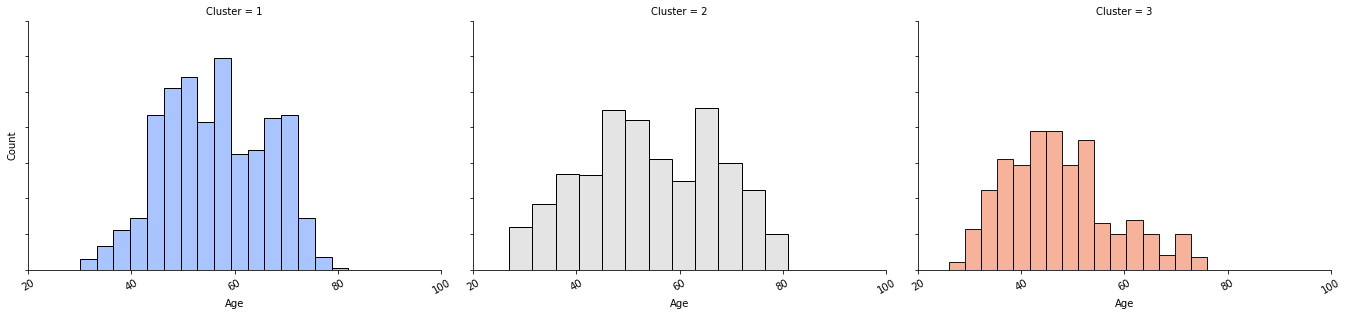

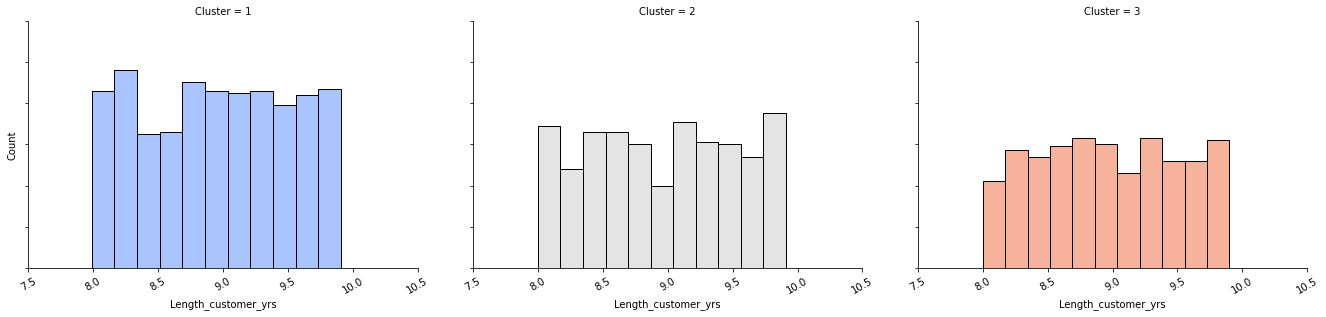

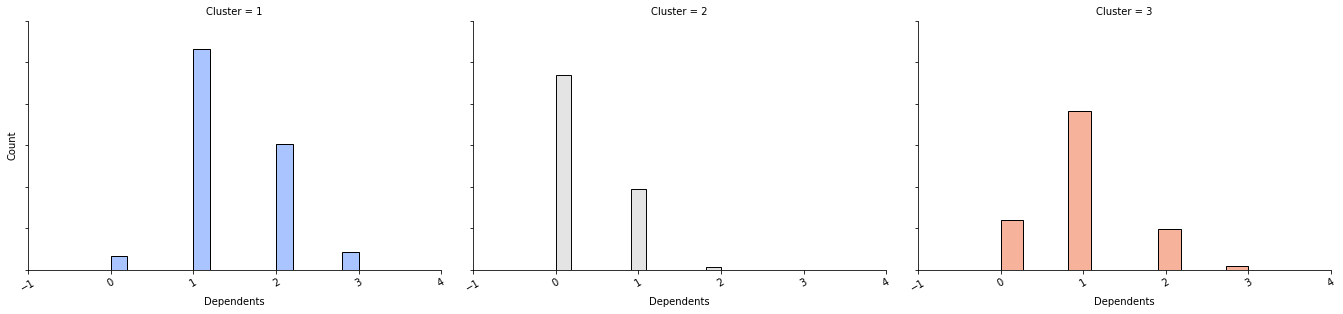

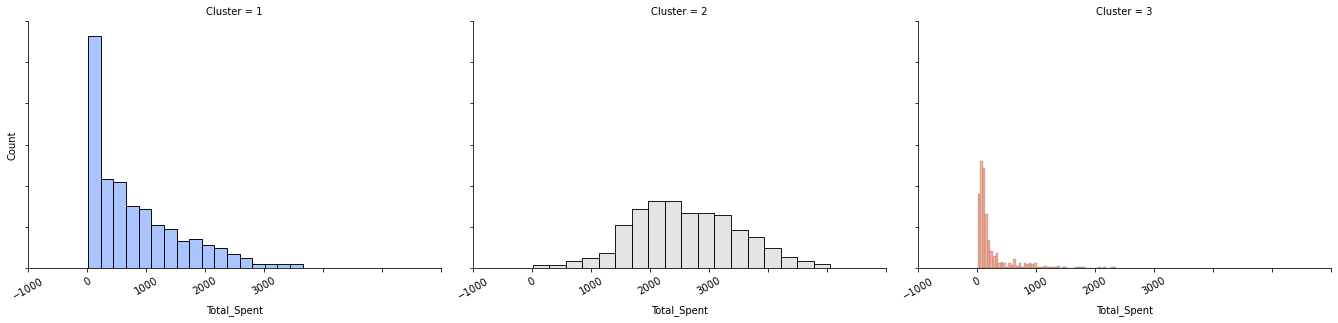

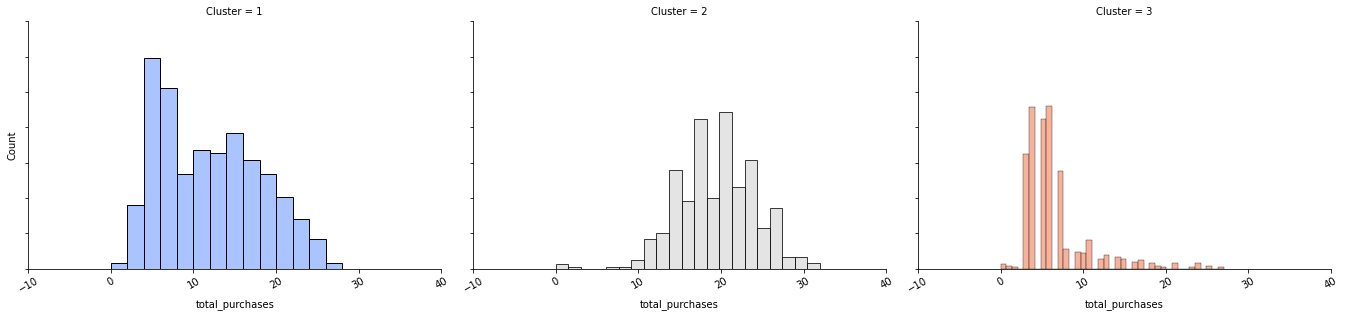

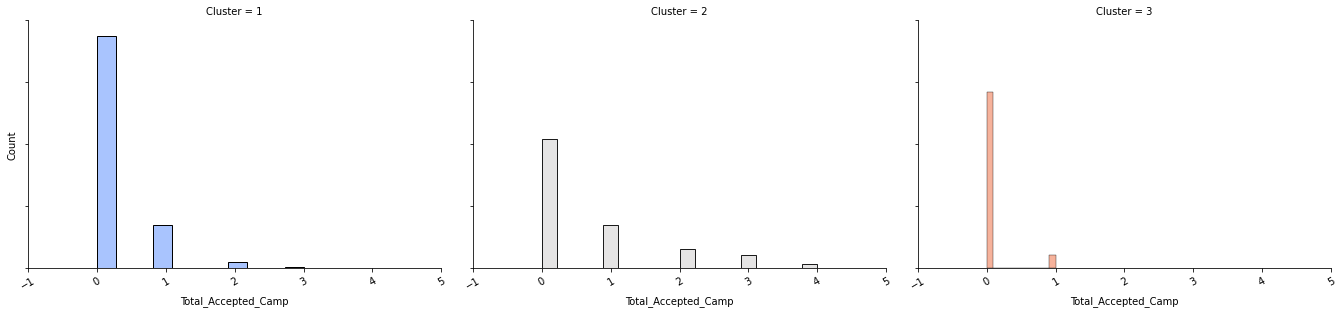

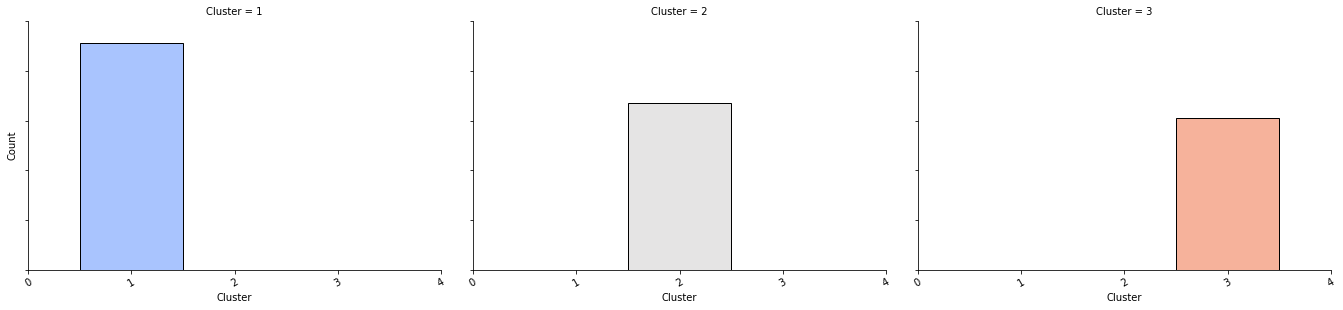

In [35]:
for i in seg_df:
    g = sns.FacetGrid(seg_df, col = "Cluster", hue = "Cluster", palette = "coolwarm", sharey=True,sharex=True)
    g.map(sns.histplot,i) 
    g.set_xticklabels(rotation=30)
    g.set_yticklabels()
    g.fig.set_figheight(5)
    g.fig.set_figwidth(20)

Cluster 1 has the most number of PhD- & MSc- holding customers.
Cluster 1 customers are more likely to spend more on fruit products than cluster 2 or 3. 
Cluster 1 also contains many customers who spend a little bit on sweets.
Cluster 1 customers are the most likely to have dependents.

Cluster 2 customers have the lowest income level.
Cluster 2 is the most likely to accept a marketing campaign.
Cluster 2 has the least number of dependents while cluster 1 has the most.
Cluster 2 customers are more likely to spend on Meat products
Cluster 2 has the least number of purchases made with a discount.
Cluster 2 is the most likely to spend the most. 
Cluster 2 customers tend to have more total number of purchases.
Cluster 2 is less likely to check the web for deals than clusters 1 or 2

Cluster 3 has younger customers.
Cluster 3 contains all customers with a basic education.
Cluster 3 is the most likely to spend more on Gold products
Cluster 3 is the smallest cluster. These customers have spent less than $500 in total.
Cluster 3 has mostly customers with less than 12 total number of purchases while cluster 1 is a mix of the other 2.

In [ ]:
# total accepted campaigns